<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_13/DNN_Assifnment_13_syntetic_face_by_DCGAN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Basic import funtion

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import cv2

#Dataset Download from kaggle

In [2]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
path1=path
print("Dataset path -----:", path)


Dataset path -----: /kaggle/input/celeba-dataset


#data processing and loading

In [4]:
import os
print(os.listdir(path))
path=os.path.join(path, "img_align_celeba", "img_align_celeba")

def load_celeba_data(data_dir, max_images= 3000):
    """Loads and preprocesses images from the CelebA dataset.

    Args:
        data_dir: Directory containing the CelebA dataset images.
        max_images: Maximum number of images to load.

    Returns:
        A numpy array of preprocessed images.
    """
    print(f"Loading CelebA dataset from {data_dir}...")

    # Get image paths
    image_paths = sorted([
        os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith(".jpg")
    ])[:max_images]

    print(f"Found {len(image_paths)} images")

    images = []
    for i, path in enumerate(image_paths):
        if i % 200 == 0:
            print(f"Processing image {i}/{len(image_paths)}")

        try:
            # Load and resize image
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64,64))

            # Normalize to [-1, 1] for tanh activation
            img = (img.astype(np.float32) - 127.5) / 127.5
            images.append(img)

        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue

    return np.array(images)

x_train=load_celeba_data(path)

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

['list_landmarks_align_celeba.csv', 'img_align_celeba', 'list_eval_partition.csv', 'list_attr_celeba.csv', 'list_bbox_celeba.csv']
Loading CelebA dataset from /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba...
Found 3000 images
Processing image 0/3000
Processing image 200/3000
Processing image 400/3000
Processing image 600/3000
Processing image 800/3000
Processing image 1000/3000
Processing image 1200/3000
Processing image 1400/3000
Processing image 1600/3000
Processing image 1800/3000
Processing image 2000/3000
Processing image 2200/3000
Processing image 2400/3000
Processing image 2600/3000
Processing image 2800/3000


#Generator model

In [5]:
def make_generator_model():
   model = tf.keras.Sequential([
            # Foundation for 4x4 image
            layers.Dense(4 * 4 * 1024, use_bias=False, input_shape=(100,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Reshape((4, 4, 1024)),

            # Upsample to 8x8
            layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            # Upsample to 16x16
            layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            # Upsample to 32x32
            layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            # Upsample to 64x64
            layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            # Final layer - output RGB image
            layers.Conv2DTranspose(3, (5, 5), strides=(1, 1),
                                 padding='same', use_bias=False, activation='tanh')
        ], name='generator')

   return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


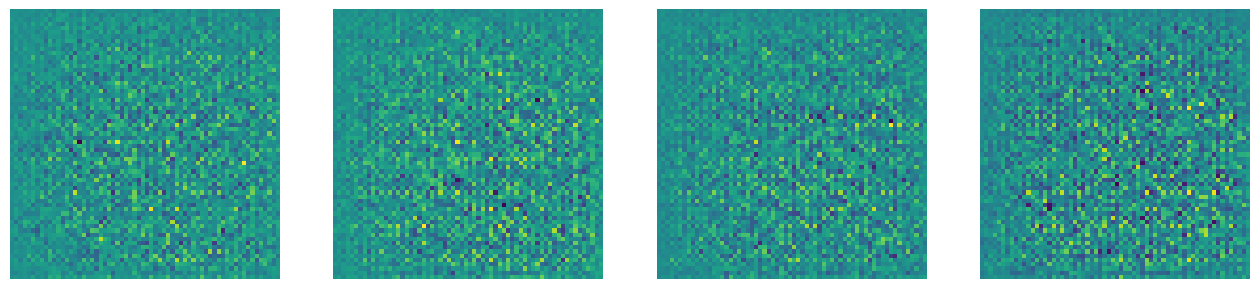

In [8]:
generator = make_generator_model()
noise = tf.random.normal([4, 100]) # Generate 4 different noise vectors
generated_images = generator(noise, training=False)

fig, axes = plt.subplots(1, 4, figsize=(16, 4)) # Create a 1x4 grid for images

for i in range(generated_images.shape[0]):
    axes[i].imshow(generated_images[i, :, :, 0]) # Display each generated image
    axes[i].axis('off') # Turn off axes for cleaner display

plt.show()

#Discriminator Model

In [9]:
def make_discriminator_model():

        model = tf.keras.Sequential([
            # Input layer
            layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                         input_shape=(64,64,3)),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            # 32x32 -> 16x16
            layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            # 16x16 -> 8x8
            layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            # 8x8 -> 4x4
            layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            # 4x4 -> 2x2
            layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            # Flatten and output
            layers.Flatten(),
            layers.Dense(1, activation='sigmoid')
        ], name='discriminator')

        return model
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.5000231]], shape=(1, 1), dtype=float32)


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = '/content/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [16]:
EPOCHS = 120
noise_dim = 100
num_examples_to_generate = 16

gen_losses = []
disc_losses = []

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    # Create the directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0  # Rescale to [0,1]

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig(f'/content/checkpoints/image_at_epoch_{epoch:04d}.png')
    plt.show()
    plt.close()

Epoch 1, Gen Loss: 6.9700, Disc Loss: 0.0404
Epoch 2, Gen Loss: 5.1951, Disc Loss: 0.0299
Epoch 3, Gen Loss: 5.5939, Disc Loss: 0.0347
Epoch 4, Gen Loss: 5.8053, Disc Loss: 0.0368
Epoch 5, Gen Loss: 6.6932, Disc Loss: 0.1793
Epoch 6, Gen Loss: 5.0542, Disc Loss: 0.0833
Epoch 7, Gen Loss: 4.8789, Disc Loss: 0.0606
Epoch 8, Gen Loss: 5.5696, Disc Loss: 0.0185
Epoch 9, Gen Loss: 5.0907, Disc Loss: 0.0362
Epoch 10, Gen Loss: 7.0316, Disc Loss: 0.0190
Epoch 11, Gen Loss: 7.7645, Disc Loss: 0.0155
Epoch 12, Gen Loss: 6.7629, Disc Loss: 0.1211
Epoch 13, Gen Loss: 9.2311, Disc Loss: 0.0529
Epoch 14, Gen Loss: 6.1898, Disc Loss: 0.0235
Epoch 15, Gen Loss: 6.8720, Disc Loss: 0.0269
Epoch 16, Gen Loss: 6.2239, Disc Loss: 0.0403
Epoch 17, Gen Loss: 8.0223, Disc Loss: 0.0101
Epoch 18, Gen Loss: 9.5431, Disc Loss: 0.0179
Epoch 19, Gen Loss: 18.7714, Disc Loss: 0.2881
Epoch 20, Gen Loss: 26.8709, Disc Loss: 0.0000
Epoch 21, Gen Loss: 3.2569, Disc Loss: 0.2703
Epoch 22, Gen Loss: 14.1401, Disc Loss: 0

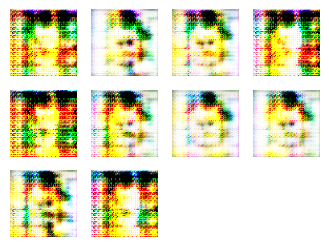

Epoch 31, Gen Loss: 5.9954, Disc Loss: 0.3593
Epoch 32, Gen Loss: 6.4057, Disc Loss: 0.4407
Epoch 33, Gen Loss: 7.1425, Disc Loss: 0.2234
Epoch 34, Gen Loss: 3.7537, Disc Loss: 0.4167
Epoch 35, Gen Loss: 7.8586, Disc Loss: 0.0149
Epoch 36, Gen Loss: 5.4669, Disc Loss: 0.0552
Epoch 37, Gen Loss: 6.4229, Disc Loss: 0.0260
Epoch 38, Gen Loss: 7.5340, Disc Loss: 0.0224
Epoch 39, Gen Loss: 5.5078, Disc Loss: 0.0261
Epoch 40, Gen Loss: 5.5714, Disc Loss: 0.0335
Epoch 41, Gen Loss: 5.1869, Disc Loss: 0.0362
Epoch 42, Gen Loss: 5.5991, Disc Loss: 0.0409
Epoch 43, Gen Loss: 6.4735, Disc Loss: 0.0727
Epoch 44, Gen Loss: 13.8191, Disc Loss: 0.5132
Epoch 45, Gen Loss: 5.2774, Disc Loss: 0.0489
Epoch 46, Gen Loss: 13.5563, Disc Loss: 0.0001
Epoch 47, Gen Loss: 11.7034, Disc Loss: 0.0001
Epoch 48, Gen Loss: 5.9889, Disc Loss: 0.0143
Epoch 49, Gen Loss: 4.6129, Disc Loss: 0.0560
Epoch 50, Gen Loss: 2.0680, Disc Loss: 0.5154
Epoch 51, Gen Loss: 18.8575, Disc Loss: 0.0932
Epoch 52, Gen Loss: 10.6982, D

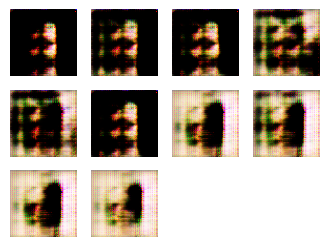

Epoch 61, Gen Loss: 7.4262, Disc Loss: 0.0302
Epoch 62, Gen Loss: 12.8856, Disc Loss: 0.1586
Epoch 63, Gen Loss: 5.4211, Disc Loss: 0.0514
Epoch 64, Gen Loss: 7.0547, Disc Loss: 0.0139
Epoch 65, Gen Loss: 3.2352, Disc Loss: 0.3503
Epoch 66, Gen Loss: 4.7520, Disc Loss: 0.0678
Epoch 67, Gen Loss: 5.2455, Disc Loss: 0.0567
Epoch 68, Gen Loss: 4.8085, Disc Loss: 0.0904
Epoch 69, Gen Loss: 3.3008, Disc Loss: 0.2203
Epoch 70, Gen Loss: 6.5025, Disc Loss: 0.0354
Epoch 71, Gen Loss: 5.6533, Disc Loss: 0.0789
Epoch 72, Gen Loss: 6.4669, Disc Loss: 0.0260
Epoch 73, Gen Loss: 5.7357, Disc Loss: 0.0259
Epoch 74, Gen Loss: 5.7113, Disc Loss: 0.0527
Epoch 75, Gen Loss: 3.9590, Disc Loss: 0.1023
Epoch 76, Gen Loss: 3.5397, Disc Loss: 0.1356
Epoch 77, Gen Loss: 5.1645, Disc Loss: 0.2407
Epoch 78, Gen Loss: 9.1081, Disc Loss: 0.0051
Epoch 79, Gen Loss: 8.5086, Disc Loss: 0.1526
Epoch 80, Gen Loss: 5.8599, Disc Loss: 0.0975
Epoch 81, Gen Loss: 4.2504, Disc Loss: 0.5974
Epoch 82, Gen Loss: 7.6081, Disc 

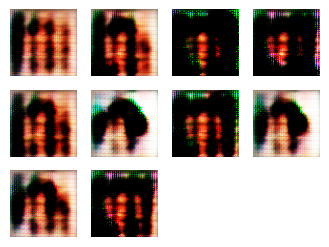

Epoch 91, Gen Loss: 7.0553, Disc Loss: 0.1188
Epoch 92, Gen Loss: 5.1127, Disc Loss: 0.0278
Epoch 93, Gen Loss: 2.2559, Disc Loss: 0.3585
Epoch 94, Gen Loss: 7.5767, Disc Loss: 0.1005
Epoch 95, Gen Loss: 6.1058, Disc Loss: 0.0671
Epoch 96, Gen Loss: 6.3279, Disc Loss: 0.1152
Epoch 97, Gen Loss: 4.1815, Disc Loss: 0.3517
Epoch 98, Gen Loss: 3.4988, Disc Loss: 0.4044
Epoch 99, Gen Loss: 6.6877, Disc Loss: 0.0285
Epoch 100, Gen Loss: 5.5874, Disc Loss: 0.0563
Epoch 101, Gen Loss: 4.0918, Disc Loss: 0.2497
Epoch 102, Gen Loss: 4.0813, Disc Loss: 0.2955
Epoch 103, Gen Loss: 2.6578, Disc Loss: 0.2520
Epoch 104, Gen Loss: 3.2660, Disc Loss: 0.1822
Epoch 105, Gen Loss: 4.5226, Disc Loss: 0.0504
Epoch 106, Gen Loss: 5.7510, Disc Loss: 0.0316
Epoch 107, Gen Loss: 4.2014, Disc Loss: 0.0626
Epoch 108, Gen Loss: 3.5213, Disc Loss: 0.1425
Epoch 109, Gen Loss: 11.1761, Disc Loss: 0.2529
Epoch 110, Gen Loss: 6.8324, Disc Loss: 0.0511
Epoch 111, Gen Loss: 3.3655, Disc Loss: 0.1370
Epoch 112, Gen Loss: 

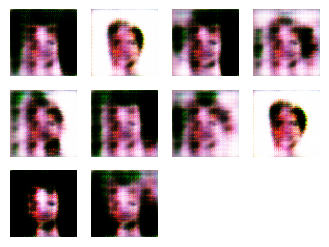

In [18]:
seed = tf.random.normal([16, 100])

for epoch in range(1, EPOCHS + 1):
    for image_batch in train_dataset:
        g_loss, d_loss = train_step(image_batch)
        gen_losses.append(g_loss.numpy())
        disc_losses.append(d_loss.numpy())
    print(f"Epoch {epoch}, Gen Loss: {g_loss.numpy():.4f}, Disc Loss: {d_loss.numpy():.4f}")
    if epoch % 30 == 0 or epoch == EPOCHS: # Generate images every 10 epochs and at the end
        generate_and_save_images(generator, epoch, tf.random.normal([10, noise_dim]))

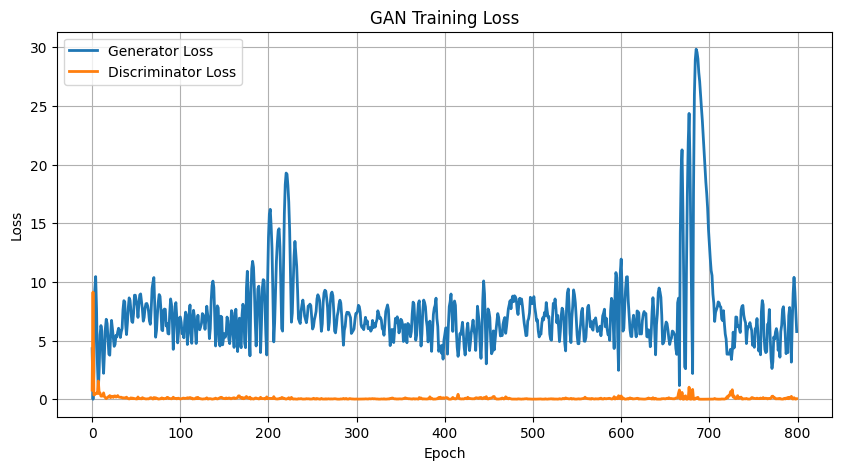

In [ ]:
# Loss curve plotting
def plot_loss_curve():
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss", linewidth=2)
    plt.plot(disc_losses, label="Discriminator Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("checkpoints/loss_curve.png", dpi=300)
    plt.show()

plot_loss_curve()